# Emotion Classification using ML Models

## imports


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report,top_k_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import numpy as np

## load datasets

In [12]:
train_df = pd.read_csv("../data/train.csv", sep=';')
val_df = pd.read_csv("../data/val.csv", sep=';')
test_df = pd.read_csv("../data/test.csv", sep=';')

train_df.columns = ['text', 'label']
val_df.columns = ['text', 'label']
test_df.columns = ['text', 'label']

print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")


Train: (16000, 2), Val: (2000, 2), Test: (2000, 2)


## combining train and validation for stronger training

In [13]:
X_train = pd.concat([train_df['text'], val_df['text']])
y_train = pd.concat([train_df['label'], val_df['label']])

X_test = test_df['text']
y_test = test_df['label']
print(f"Combined Train: {X_train.shape}, Test: {X_test.shape}")

Combined Train: (18000,), Test: (2000,)


## text vectorization

In [14]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## train models

In [20]:
# Logistic Regression
lr = LogisticRegression(max_iter=200, random_state=42)
lr.fit(X_train_vec, y_train);

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_vec, y_train);

## evaluation function

In [21]:
def evaluate(model, name, X_test_vec, y_test, save_plot=False):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        roc_auc_score, top_k_accuracy_score, classification_report, confusion_matrix
    )
    from sklearn.preprocessing import LabelEncoder

    y_pred = model.predict(X_test_vec)

    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_vec)

    le = LabelEncoder()
    y_true_enc = le.fit_transform(y_test)
    y_pred_enc = le.transform(y_pred)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec  = recall_score(y_test, y_pred, average='weighted')
    f1   = f1_score(y_test, y_pred, average='weighted')

    if y_proba is not None:
        try:
            topk = top_k_accuracy_score(y_true_enc, y_proba, k=3)
        except Exception:
            topk = None
    else:
        topk = None

    auc = None
    if y_proba is not None and len(np.unique(y_true_enc)) > 1:
        try:
            auc = roc_auc_score(y_true_enc, y_proba, multi_class='ovr', average='macro')
        except Exception:
            auc = None

    em = np.mean(y_test.to_numpy() == y_pred)

    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | "
          f"F1: {f1:.3f} | AUC: {auc if auc else 0:.3f} | EM: {em:.3f} | Top-3: {topk if topk else 0:.3f}")

    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()  

    if save_plot:
        plt.savefig(f"../plots/{name}_confusion_matrix.png", dpi=300, bbox_inches='tight')
        print(f"Saved confusion matrix as {name}_confusion_matrix.png")

    plt.show()  
    plt.close() 

    return {
        "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
        "auc": auc, "exact_match": em, "top3": topk
    }


## evaluate for logistic regression


Logistic Regression Results:
Accuracy: 0.877 | Precision: 0.877 | Recall: 0.877 | F1: 0.874 | AUC: 0.990 | EM: 0.877 | Top-3: 0.994

Classification Report:
               precision    recall  f1-score   support

       anger       0.88      0.83      0.85       275
        fear       0.88      0.81      0.84       224
         joy       0.86      0.95      0.91       695
        love       0.83      0.69      0.75       159
     sadness       0.91      0.92      0.91       581
    surprise       0.88      0.53      0.66        66

    accuracy                           0.88      2000
   macro avg       0.87      0.79      0.82      2000
weighted avg       0.88      0.88      0.87      2000

Saved confusion matrix as Logistic Regression_confusion_matrix.png


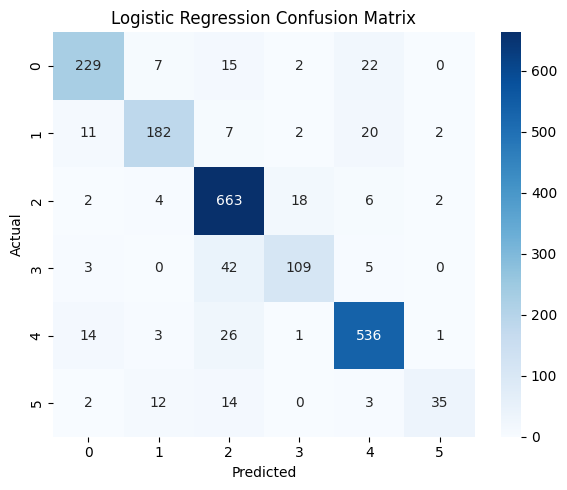

In [23]:
log_reg_metrices = evaluate(lr, "Logistic Regression", X_test_vec, y_test,save_plot=True)

## evaluate for random forest


Random Forest Results:
Accuracy: 0.880 | Precision: 0.881 | Recall: 0.880 | F1: 0.880 | AUC: 0.991 | EM: 0.880 | Top-3: 0.997

Classification Report:
               precision    recall  f1-score   support

       anger       0.90      0.89      0.89       275
        fear       0.83      0.91      0.86       224
         joy       0.89      0.91      0.90       695
        love       0.74      0.72      0.73       159
     sadness       0.94      0.91      0.93       581
    surprise       0.69      0.62      0.66        66

    accuracy                           0.88      2000
   macro avg       0.83      0.82      0.83      2000
weighted avg       0.88      0.88      0.88      2000

Saved confusion matrix as Random Forest_confusion_matrix.png


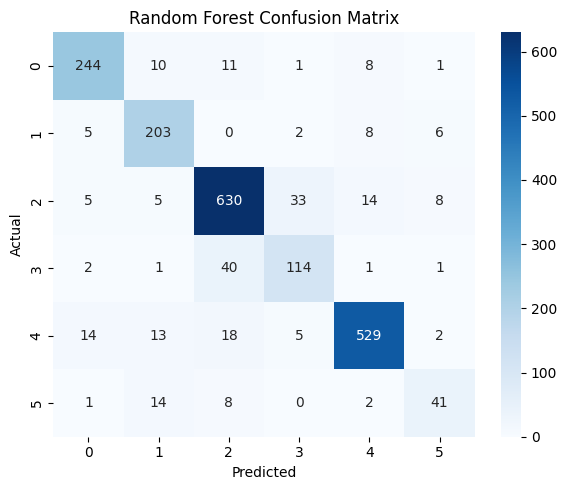

In [24]:
rf_metrics = evaluate(rf, "Random Forest", X_test_vec, y_test,save_plot=True)

## save models

In [25]:
results = {
    "LogisticRegression": log_reg_metrices,
    "RandomForest": rf_metrics
}

with open("classification_metrics.json", "w") as f:
    json.dump(results, f, indent=4)
    
print("\n✅ Metrics saved to classification_metrics.json")
print("✅ Confusion matrices saved in /plots folder")


✅ Metrics saved to classification_metrics.json
✅ Confusion matrices saved in /plots folder
